# Income Range, US Census 1994

Data from: https://archive.ics.uci.edu/ml/datasets/Adult

Task is to classify income into two groups: less than or equal to 50k/year, or more than 50k/year

## Helper Functions

In [1]:
%matplotlib inline

import collections
import os
import os.path

import pandas as pd
import numpy as np
import sklearn
from ggplot import *
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def plot_interactive_tree(model, feature_names, class_names=None):
    from IPython.display import Image  
    from sklearn import tree
    import pydotplus 
    dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=feature_names,
                         class_names=class_names,
                         filled=True, rounded=True,  
                         special_characters=True)  

    graph = pydotplus.graph_from_dot_data(dot_data.decode('ascii').encode('utf8'))  

    return Image(graph.create_png()) 


def plot_kfold_roc_auc(classifier, X, y, k=5):
    from scipy import interp
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold
    from sklearn.metrics import classification_report

    cv = StratifiedKFold(y, n_folds=k)
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    
    y_true = []
    y_pred = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        
        y_pred.extend(np.argmax(probas_, axis=1))
        y_true.extend(y.iloc[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print classification_report(y_true, y_pred)
    
    
def plot_roc_and_metrics(classifier, X, y):
    from sklearn import metrics

    preds = classifier.predict_proba(X)[:,1]
    fpr, tpr, _ = metrics.roc_curve(y, preds)

    print 'Testing AUC: {:.3f}'.format(metrics.roc_auc_score(y, preds))

    print metrics.classification_report(y, [round(x) for x in preds])

    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    print ggplot(df, aes(x='fpr', y='tpr')) +\
        geom_line() +\
        geom_abline(linetype='dashed')    
    

In [3]:
DATA_DIR = '.data'

## Pre-processing


Following steps were taken:
  - Strings were stripped (to remove spaces)
  - All categorical features were one-hot-encoded into independent features
  - Output variable was converted to a binary feature
  

In [4]:
from sklearn import preprocessing

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship',
              'race', 'sex', 'native-country']

def read_data(kind='train'):
    '''
    >50K, <=50K.

    age: continuous.
    workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    fnlwgt: continuous.
    education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
    education-num: continuous.
    marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
    occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
    relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
    race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
    sex: Female, Male.
    capital-gain: continuous.
    capital-loss: continuous.
    hours-per-week: continuous.
    native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.    
    '''
    
    
    filename = 'adult.data' if kind == 'train' else 'adult.test'
    filepath = os.path.join(DATA_DIR, filename)
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
              'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'y']
    
    
    if os.path.exists(filepath) == False:
        if os.path.exists(DATA_DIR) == False:
            os.makedirs(DATA_DIR)
        import urllib
        source_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/%s' % filename
        print 'Downloading file %s' % filename
        urllib.urlretrieve (source_url, filepath)
    
    skip_rows = 1 if filename == 'adult.test' else 0
    df = pd.read_csv(filepath, header=None, skiprows=skip_rows)
    df.columns = columns
    
    for c in categorical_features:
        df[c] = df[c].map(lambda x: x.strip())
    
    df.replace('?', 'Unknown', inplace=True)
    df['y'] = df['y'].map(lambda x: x.strip()).map(lambda x: '<=50K' if '<=50K' in x else x).map(lambda x: '>50K' if '>50K' in x else x)
    df['y'] = df['y'].map(lambda x: 0 if x == '<=50K' else 1)
    
    for c in categorical_features:
        df[c] = df[c].astype("category")
    return df


def pre_proc_ohe(data_frames, categorical_features):
    category_values = collections.defaultdict(set)
    
    for c in categorical_features:
        values = []
        for df in data_frames:

            values.extend(df[c].unique())
        
        category_values[c] = sorted(set(values))
        
    for k,v in category_values.items():
        #print k, '==>', v, '\n'
        pass
    
    new_data_frames = [df.copy() for df in data_frames]
    for c in categorical_features:
        for v in category_values[c]:
            cname = '%s_%s' % (c, v)
            for idx, df in enumerate(data_frames):
                new_data_frames[idx][cname] = df[c].map(lambda x: 1 if x == v else -1)
    
    for df in new_data_frames:
        df.drop(categorical_features, axis=1, inplace=True)
        
    return new_data_frames
    
def ml_split(df):
    
    X = df.drop(['y'], axis=1)
    y = df['y']
    
    return X, y

In [5]:
train = read_data('train')
test = read_data('test')

train.head(5)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Classification: One Learner

### OHE-DT

In [6]:
def clf_ohe_single_decision_tree(train, test):
    train_dt, test_dt = pre_proc_ohe([train, test], categorical_features)
    Xtrain_dt, ytrain_dt = ml_split(train_dt)
    Xtest_dt, ytest_dt = ml_split(test_dt) 
    
    from sklearn import tree

    decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=50, random_state=1)
    decision_tree  
    
    plot_kfold_roc_auc(decision_tree, 
                       pd.concat([Xtrain_dt, Xtest_dt], ignore_index=True), 
                       pd.concat([ytrain_dt, ytest_dt], ignore_index=True), 
                       k=5)    
    
    importances = decision_tree.feature_importances_

    importances = decision_tree.feature_importances_
    std = np.std([decision_tree.feature_importances_],
                 axis=0)

    indices = np.argsort(importances)[::-1]
    
    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtrain_dt.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, Xtrain_dt.columns[indices[f]], importances[indices[f]]))
        
    feat_important_indeces = [Xtrain_dt.columns[indices[f]] for f in range(Xtrain_dt.shape[1])]
    _ = plt.figure(figsize=(24, 24))
    _ = plt.title("Feature importances")
    _ = plt.barh(range(Xtrain_dt.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    _ = plt.yticks(range(Xtrain_dt.shape[1]), feat_important_indeces)
    _ = plt.ylim([-1, Xtrain_dt.shape[1]])

    plt.show()        


/home/guilherme/SDK/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


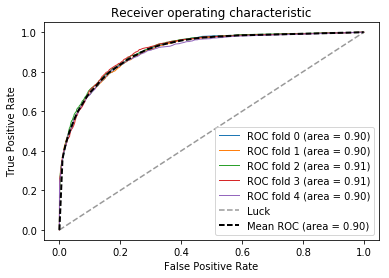

             precision    recall  f1-score   support

          0       0.88      0.94      0.91     37155
          1       0.75      0.60      0.67     11687

avg / total       0.85      0.86      0.85     48842

Feature ranking:
1. feature marital-status_Married-civ-spouse (0.389821)
2. feature education-num (0.206929)
3. feature capital-gain (0.184414)
4. feature capital-loss (0.055122)
5. feature age (0.048661)
6. feature hours-per-week (0.038635)
7. feature fnlwgt (0.020084)
8. feature occupation_Exec-managerial (0.014956)
9. feature workclass_Self-emp-not-inc (0.006493)
10. feature occupation_Prof-specialty (0.006228)
11. feature education_HS-grad (0.004227)
12. feature education_Masters (0.003536)
13. feature occupation_Farming-fishing (0.002659)
14. feature relationship_Wife (0.002494)
15. feature occupation_Other-service (0.002431)
16. feature sex_Male (0.001964)
17. feature sex_Female (0.001895)
18. feature occupation_Sales (0.001829)
19. feature occupation_Protective-serv (

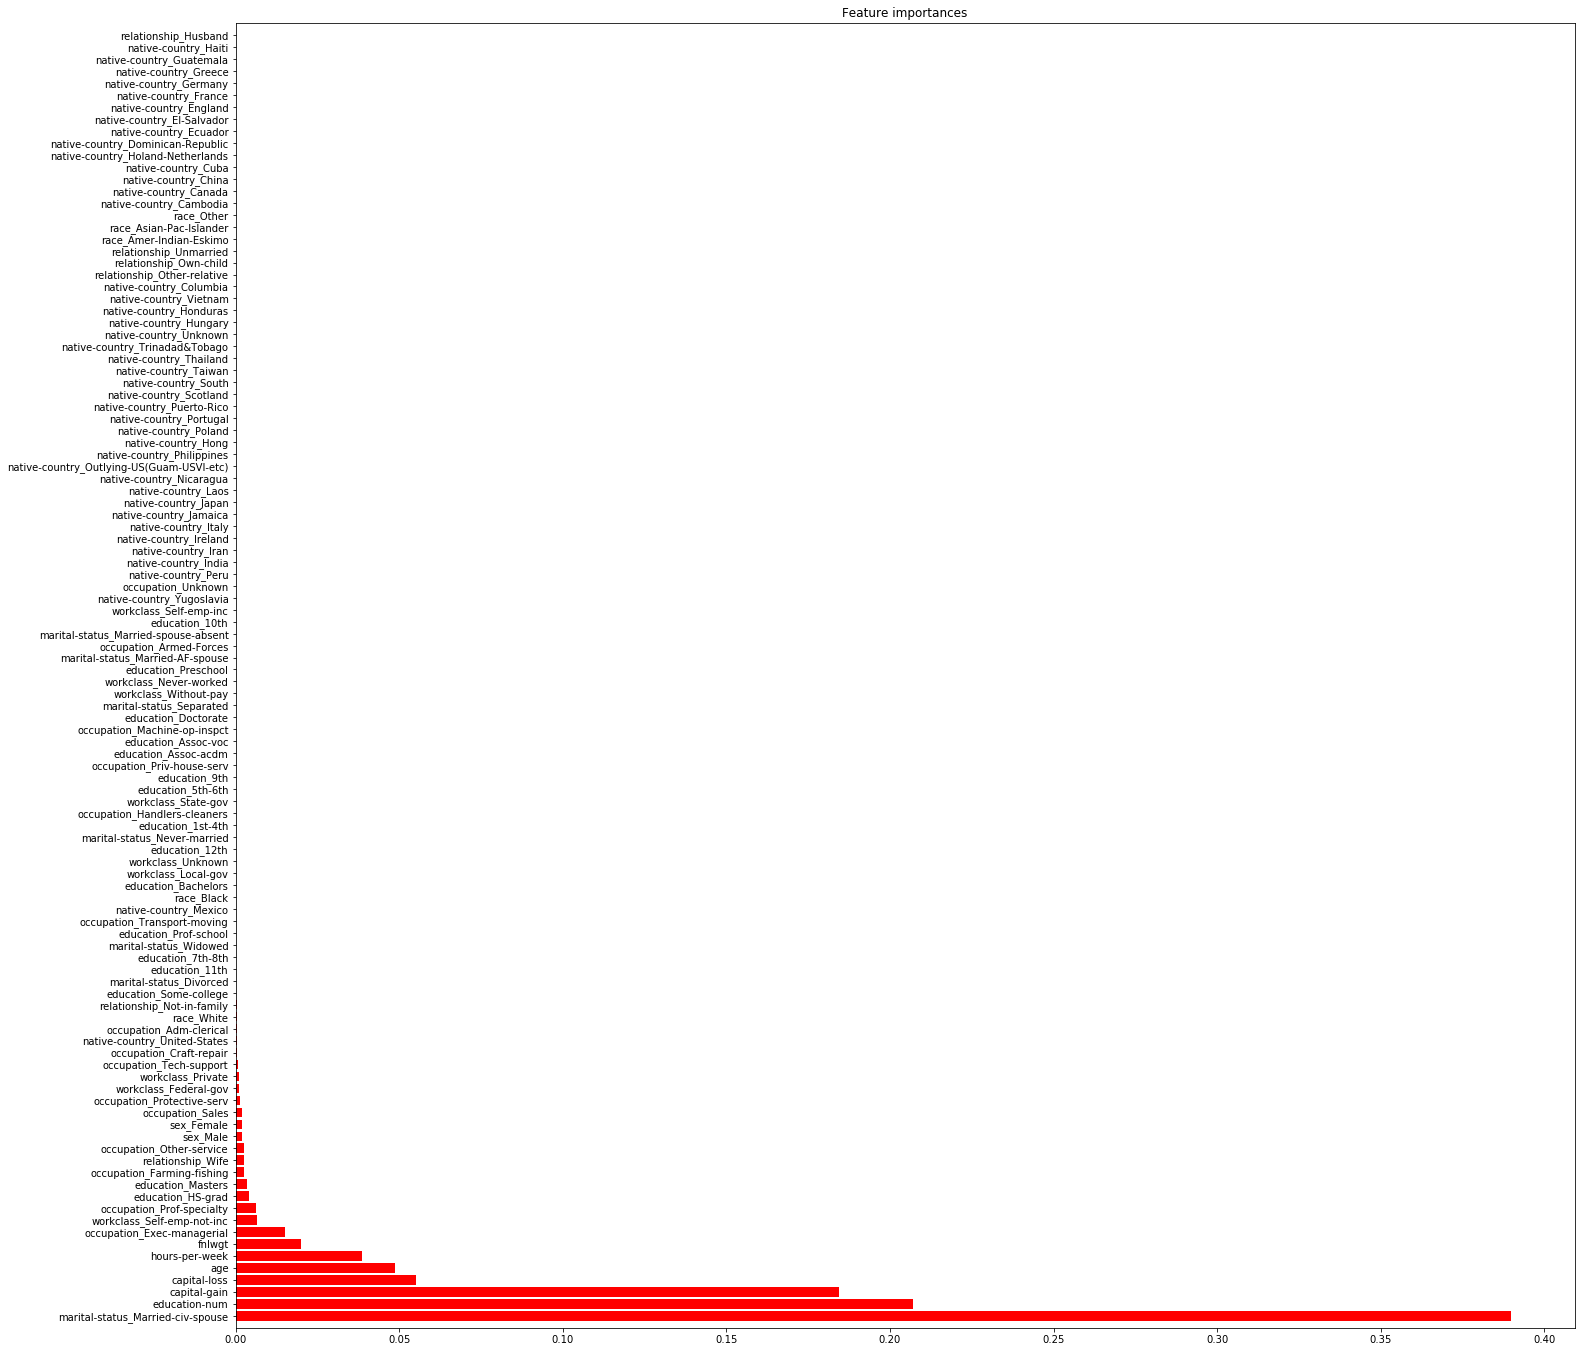

In [7]:
clf_ohe_single_decision_tree(train, test)

### OHE-ANN-Linear

In [8]:
def clf_ohe_single_nn(train, test):

    train_nn, test_nn = pre_proc_ohe([train, test], categorical_features)
    Xtrain_nn, ytrain_nn = ml_split(train_nn)
    Xtest_nn, ytest_nn = ml_split(test_nn)
    
    from sklearn.neural_network import MLPClassifier

    nn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=[3] + [1 for _ in range(10)], random_state=1,
                      learning_rate='constant', learning_rate_init=.0005, max_iter=int(1e4), activation='identity')
    nn    
    
    Xfull_nn = pd.concat([Xtrain_nn, Xtest_nn], ignore_index=True)
    yfull_nn = pd.concat([ytrain_nn, ytest_nn], ignore_index=True)
    scaler = preprocessing.StandardScaler().fit(Xfull_nn)
    
    Xfull_nn_scaled = pd.DataFrame(scaler.transform(Xfull_nn))

    plot_kfold_roc_auc(nn, Xfull_nn_scaled, yfull_nn, k=5)

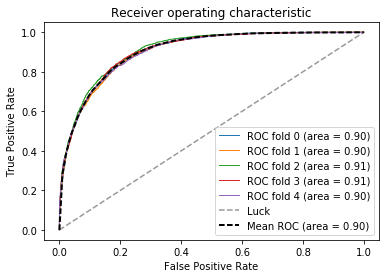

             precision    recall  f1-score   support

          0       0.88      0.93      0.91     37155
          1       0.73      0.61      0.66     11687

avg / total       0.85      0.85      0.85     48842



In [9]:
clf_ohe_single_nn(train, test)

Notes:

  - Binary encoding did not work with an architecture with multiple neurons per layer. And also, features should have been normalized
  - Different variations of architecture were tested (higher number of layers, neurons per layer), and nothing helped

### HT-ANN-Relu

In [10]:
def clf_ht_single_nn(train, test):

    N = 36
    def hash_fn(x):
        tmp = [0 for _ in range(N)]
        for val in x.values:
            tmp[hash(val) % N] += 1
        return pd.Series(tmp, index=cols)
    cols = ['col_%d' % d for d in range(N)]
    
    X = pd.concat([train.drop(['y'], axis=1), test.drop(['y'], axis=1)], ignore_index=True)
    y = pd.concat([train['y'], test['y']], ignore_index=True)

    X_ht = X[categorical_features].apply(hash_fn, axis=1)

    for c in X.columns:
        if (c not in categorical_features) and c != 'y':
            X_ht[c] = X[c]

    scaler = preprocessing.StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_ht))

    X_scaled.head(5)
    
    from sklearn.neural_network import MLPClassifier
    
    nn = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=[16 for _ in range(20)], random_state=1,
                  learning_rate='constant', learning_rate_init=.0005, max_iter=int(1e4), activation='relu')
    
    plot_kfold_roc_auc(nn, X_scaled, y, k=5)

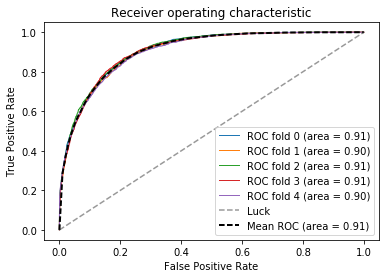

             precision    recall  f1-score   support

          0       0.88      0.93      0.91     37155
          1       0.73      0.60      0.66     11687

avg / total       0.84      0.85      0.85     48842



In [11]:
clf_ht_single_nn(train, test)

Notes:

  - With hashing of categorical features, NN performs is much better
  - Normalizing all features (numerical and hashed values) improved results by 1pp
  - Reducing hashing dimension from 64 to 48 did not change results
  - Increasing layers depth from 16 to 20 helped improve performance
  
    

# Notes

## Features: multi-variable binary encoding

Method 1: k-fold cross validation, k = 4
Method 2: train/test

### Decision Tree

  - With no restriction (min leaf samples = 1), 75% AUC. High overfitting
  - Setting min leaf samples to 50 gets performance to 90%


### ANN

Configuration: alpha=1e-05, batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,  hidden_layer_sizes=[20], learning_rate='constant', learning_rate_init=0.0005, max_iter=10000, momentum=0.9,        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False, warm_start=False

20[1]
 
- Every activation other than identity gets poor performance. Identity gets 80% AUC (learning rate 0.003)
- Reducing learning rate to 0.001 gives 85% AUC
- Reducing learning rate to 0.0005 gives 86% AUC
- Changing architecture to [3] + 20[1] increases AUC to 87%
- Normalizing data gives 88% AUC
- [3]+30[1] fails. Too long for backpropagation?
- [3]+10[1] also gets 88% with normalized (based on training, and applied to testing) data
- [3]+10[1] on full data set (cause we're using kfold CV, so whole data set is fed to the model) gives 90% AUC
- Is this an equivalent to logistic regression?


Limiting the network to a single neuron per layers prevent the zero-ing effect from fully connected neurons.
Additions happens in the first layer, and the following layers simple learn a linear activation
As we increase the number of neurons, we increase exposure of neurons in other layers to dead neurons

What we're doing f(g(h(j(x)))) where each function has a single parameter to tune


Single layer, 20 neurons

  - 72% AUC


## Features: Hashing Trick, with N

Method 1: k-fold cross validation, k = 4
Method 2: train/test


### ANN

Configuration: alpha=1e-05, batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,  hidden_layer_sizes=[20], learning_rate='constant', learning_rate_init=0.0005, max_iter=10000, momentum=0.9,        nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False, warm_start=False

[3]+20[1]

  - N=48, 90% AUC
  
  
20[16]

  - N=36, 91% AUC




